# Exploring Dandiset 001174: Calcium Imaging in SMA and M1 of Macaques

**⚠️ CAUTION: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Exercise caution when interpreting the code or results. ⚠️**

## Overview

This notebook explores Dandiset 001174, which contains calcium imaging data recorded from the supplementary motor area (SMA) and primary motor cortex (M1) of macaque monkeys. The researchers used one-photon calcium imaging with microendoscopes to record neural activity during rest and during an arm reaching task.

The study is particularly relevant for understanding motor control in both healthy conditions and movement disorders. Using calcium imaging techniques, the researchers were able to examine activity patterns of projection neurons in the deep layers of SMA and M1, track activity across different conditions, examine cell pairs for synchronous activity, and assess sequential activation patterns.

You can view this dataset on Neurosift at: [https://neurosift.app/dandiset/001174](https://neurosift.app/dandiset/001174)

## What We'll Cover

In this notebook, we will:

1. Load the Dandiset using the DANDI API
2. Explore the structure of an NWB file from this dataset
3. Examine the calcium imaging data and ROI masks
4. Visualize and analyze fluorescence traces and neural activity
5. Explore correlations between different neurons

## Required Packages

The following packages are required to run this notebook:

In [1]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import h5py
import remfile
import pynwb
from dandi.dandiapi import DandiAPIClient

# Set seaborn styling for plots
sns.set_theme()

## Loading the Dandiset Using the DANDI API

First, let's connect to the DANDI archive and load our dataset. We'll start by getting the Dandiset metadata and listing available assets.

In [2]:
# Connect to DANDI archive
client = DandiAPIClient()
dandiset = client.get_dandiset("001174")

# Get basic Dandiset information
print(f"Dandiset ID: {dandiset.identifier}")
print(f"Version: {dandiset.version}")

# Try to get metadata from the dandiset object, with fallback to known values
# The property access might vary depending on the DANDI API version
try:
    name = dandiset.name if hasattr(dandiset, 'name') else "Calcium imaging in SMA and M1 of macaques"
    description = dandiset.description if hasattr(dandiset, 'description') else (
        "The study of motor cortices in non-human primates is relevant to our understanding of human motor control, "
        "both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study "
        "of multiple genetically identified neurons with excellent spatial resolution...")
except Exception as e:
    print(f"Note: Could not access metadata directly from the API: {e}")
    name = "Calcium imaging in SMA and M1 of macaques"
    description = "The study of motor cortices in non-human primates is relevant to our understanding of human motor control..."

print(f"Name: {name}")
print(f"Description: {description[:300]}...")  # Truncate for readability

# Get a list of assets
assets = list(dandiset.get_assets())
print(f"\nFound {len(assets)} assets in the dataset")

# Display first 5 assets
print("\nFirst 5 assets:")
for i, asset in enumerate(assets[:5]):
    print(f"- {asset.path} ({asset.size / 1e9:.2f} GB)")

Dandiset ID: 001174
Version: 0.250331.2218
Name: Calcium imaging in SMA and M1 of macaques
Description: The study of motor cortices in non-human primates is relevant to our understanding of human motor control, both in healthy conditions and in movement disorders. Calcium imaging and miniature microscopes allow the study of multiple genetically identified neurons with excellent spatial resolution......

Found 45 assets in the dataset

First 5 assets:
- sub-V/sub-V_ses-20230309T110929_ophys.nwb (10.66 GB)
- sub-Q/sub-Q_ophys.nwb (0.79 GB)
- sub-Q/sub-Q_ses-20220922T131747_ophys.nwb (0.79 GB)
- sub-Q/sub-Q_ses-20221003T131952_ophys.nwb (1.70 GB)
- sub-Q/sub-Q_ses-20221028T121142_ophys.nwb (1.56 GB)


## Exploring an NWB File

Now that we have an overview of the dataset, let's select one NWB file to explore in more detail. We'll select a recording from subject F and examine its content.

In [3]:
# Try to dynamically find an appropriate asset
selected_asset = None
default_asset_id = "193fee16-550e-4a8f-aab8-2383f6d57a03"  # Known good asset as fallback

# First try to find a Subject F file dynamically
for asset in assets:
    if "sub-F" in asset.path and "ophys.nwb" in asset.path:
        selected_asset = asset
        break

# If we couldn't find one, use the default
if selected_asset:
    print(f"Selected asset: {selected_asset.path}")
    print(f"Asset ID: {selected_asset.identifier}")
    print(f"Size: {selected_asset.size / 1e9:.2f} GB")
    
    # Construct the download URL
    download_url = f"https://api.dandiarchive.org/api/assets/{selected_asset.identifier}/download/"
else:
    print("Could not find suitable Subject F asset, using default")
    
    # Use hardcoded values if we couldn't find one dynamically
    file_path = "sub-F/sub-F_ses-20240213T110430_ophys.nwb"
    print(f"Selected asset: {file_path}")
    print(f"Asset ID: {default_asset_id}")
    download_url = f"https://api.dandiarchive.org/api/assets/{default_asset_id}/download/"

print(f"Download URL: {download_url}")

Selected asset: sub-F/sub-F_ses-20240213T110430_ophys.nwb
Asset ID: 193fee16-550e-4a8f-aab8-2383f6d57a03
Size: 12.39 GB
Download URL: https://api.dandiarchive.org/api/assets/193fee16-550e-4a8f-aab8-2383f6d57a03/download/


In [4]:
# Load the selected NWB file
url = download_url  # Using the URL we constructed above
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

# Display basic file information
print(f"Session description: {nwb.session_description}")
print(f"Session start time: {nwb.session_start_time}")
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Subject species: {nwb.subject.species}")
print(f"Subject sex: {nwb.subject.sex}")
print(f"Subject age: {nwb.subject.age}")

Session description: Calcium imaging in SMA during the spontaneous condition
Session start time: 2024-02-13 11:04:30.267000+00:00
Subject ID: F
Subject species: Macaca mulatta
Subject sex: F
Subject age: P5Y


## Examining Calcium Imaging Data

Let's explore the calcium imaging data in this file. The data is stored in the NWB file as a OnePhotonSeries, which contains the raw imaging data, and processed data in the ophys module.

In [5]:
# Examine the OnePhotonSeries
one_photon_series = nwb.acquisition["OnePhotonSeries"]
print("OnePhotonSeries information:")
print(f"Starting time: {one_photon_series.starting_time}")
print(f"Rate: {one_photon_series.rate} Hz")
print(f"Description: {one_photon_series.description}")
print(f"Unit: {one_photon_series.unit}")
print(f"Data shape: {one_photon_series.data.shape}")
print(f"Data type: {one_photon_series.data.dtype}")

# Examine the imaging plane
imaging_plane = nwb.imaging_planes["ImagingPlane"]
print("\nImaging plane information:")
print(f"Description: {imaging_plane.description}")
print(f"Imaging rate: {imaging_plane.imaging_rate} Hz")
print(f"Excitation wavelength: {imaging_plane.excitation_lambda} nm")
print(f"Location: {imaging_plane.location}")
print(f"Indicator: {imaging_plane.indicator}")

# Note the missing location and indicator information
if imaging_plane.location == "N/A" or imaging_plane.indicator == "N/A":
    print("\nNote: Some imaging plane fields are listed as 'N/A'. For more detailed information about the")
    print("imaging protocol, including location and calcium indicator specifics, please refer to the")
    print("published paper by Galvan et al. associated with this dataset.")

# Examine the device
device = imaging_plane.device
print("\nDevice information:")
print(f"Name: {device.name}")
print(f"Description: {device.description}")
print(f"Manufacturer: {device.manufacturer}")

OnePhotonSeries information:
Starting time: 0.0
Rate: 10.0 Hz
Description: Miniscope imaging data
Unit: fluorescence
Data shape: (6026, 1280, 800)
Data type: uint16

Imaging plane information:
Description: The plane being imaged by the miniscope
Imaging rate: 10.0 Hz
Excitation wavelength: 475.0 nm
Location: N/A
Indicator: N/A

Note: Some imaging plane fields are listed as 'N/A'. For more detailed information about the
imaging protocol, including location and calcium indicator specifics, please refer to the
published paper by Galvan et al. associated with this dataset.

Device information:
Name: Miniscope
Description: NVista3
Manufacturer: Inscopix, Inc.


## Exploring ROI Masks (Cell Footprints)

Next, let's examine the ROI masks, which represent the spatial footprints of the detected cells. These masks show where in the image each cell is located.

In [6]:
# Get the ophys processing module
ophys = nwb.processing["ophys"]
print(f"Processing module description: {ophys.description}")

# Get the image segmentation data
image_seg = ophys.data_interfaces["ImageSegmentation"]
plane_seg = image_seg.plane_segmentations["PlaneSegmentation"]

# Get information about ROIs
num_rois = len(plane_seg.id)
print(f"Number of ROIs: {num_rois}")
print(f"Columns available: {plane_seg.colnames}")

# Note the low number of ROIs
if num_rois < 10:  # Usually calcium imaging has many more ROIs
    print("\nNote: The number of ROIs in this file is unusually low for calcium imaging data.")
    print("This may indicate that:")
    print("  - This is a test/debug file with a limited number of neurons")
    print("  - Only a subset of high-quality ROIs was included")
    print("  - The segmentation process may have been conservative")
    print("  - This file might focus on specific neurons of interest")

# Check the size of the ROI masks
first_mask = plane_seg.image_mask[0]
print(f"ROI mask dimensions: {first_mask.shape}")

Processing module description: Optical physiology data obtained by processing raw calcium imaging data
Number of ROIs: 6
Columns available: ('image_mask',)

Note: The number of ROIs in this file is unusually low for calcium imaging data.
This may indicate that:
  - This is a test/debug file with a limited number of neurons
  - Only a subset of high-quality ROIs was included
  - The segmentation process may have been conservative
  - This file might focus on specific neurons of interest
ROI mask dimensions: (318, 198)


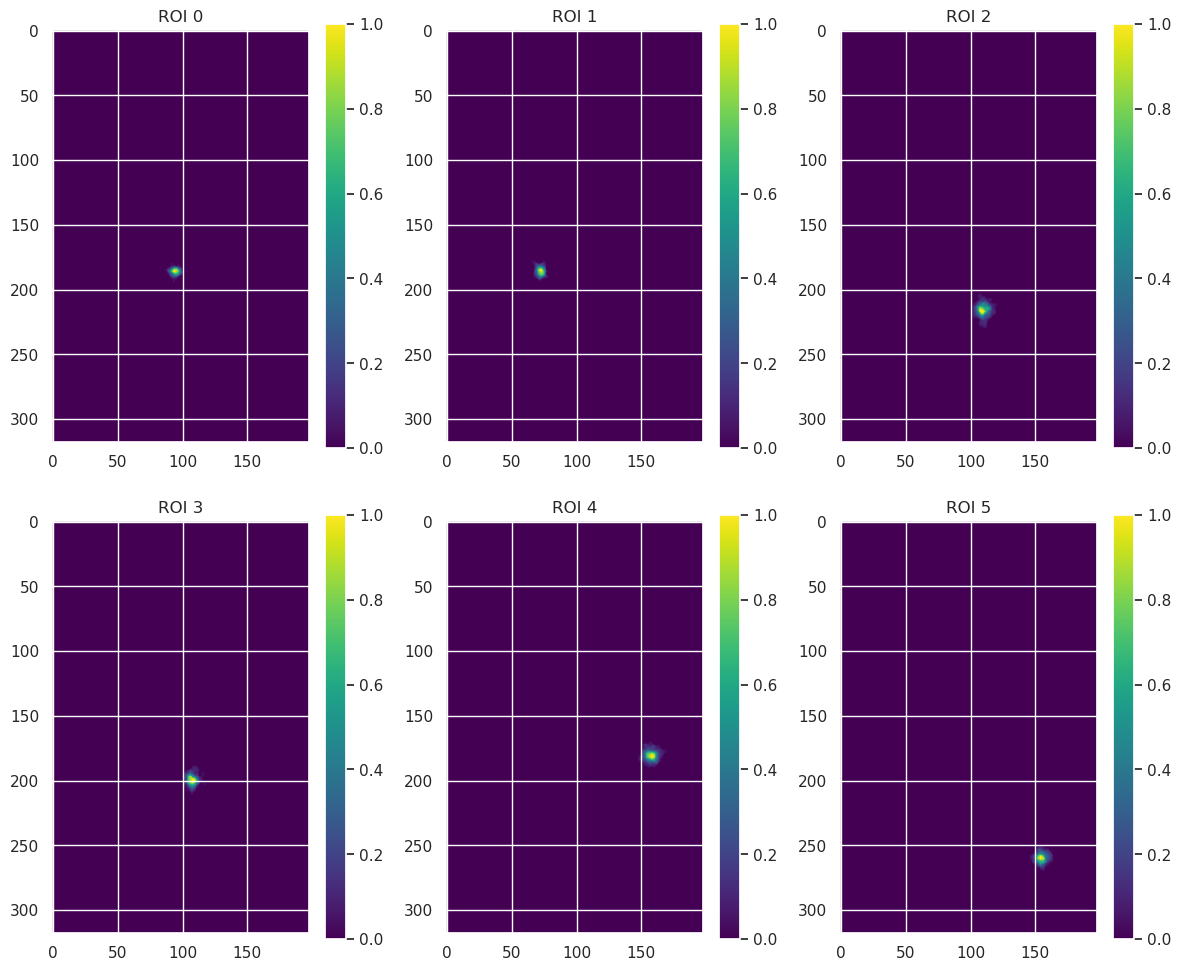

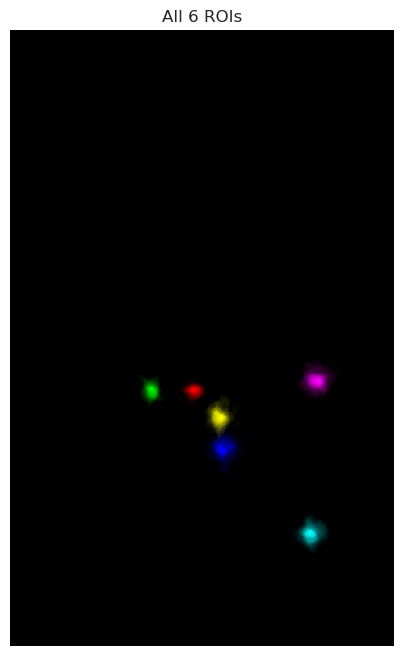

In [7]:
# Create a figure to display ROI masks
plt.figure(figsize=(12, 10))
for i in range(min(num_rois, 6)):  # Display at most 6 ROIs
    plt.subplot(2, 3, i+1)
    mask = plane_seg.image_mask[i]
    plt.imshow(mask, cmap='viridis')
    plt.title(f"ROI {i}")
    plt.colorbar()
plt.tight_layout()
plt.show()

# Create a combined view of all ROIs
plt.figure(figsize=(10, 8))

# Create a combined mask where each ROI has a different color
mask_height, mask_width = first_mask.shape
combined_mask = np.zeros((mask_height, mask_width, 3))

# Assign a different color to each ROI
colors = [
    [1, 0, 0],    # Red
    [0, 1, 0],    # Green
    [0, 0, 1],    # Blue
    [1, 1, 0],    # Yellow
    [1, 0, 1],    # Magenta
    [0, 1, 1],    # Cyan
]

# Add each ROI to the combined mask
for i in range(min(num_rois, len(colors))):
    mask = plane_seg.image_mask[i]
    for c in range(3):  # RGB channels
        combined_mask[:, :, c] += mask * colors[i][c]

# Clip values to [0, 1] range
combined_mask = np.clip(combined_mask, 0, 1)

plt.imshow(combined_mask)
plt.title(f"All {num_rois} ROIs")
plt.axis('off')
plt.show()

## Analyzing Fluorescence Traces

Now let's examine the fluorescence traces from each ROI, which show how the calcium signal in each cell changes over time. These signals correspond to neural activity.

In [8]:
# Get the fluorescence data
fluor = ophys.data_interfaces["Fluorescence"]
roi_response = fluor.roi_response_series["RoiResponseSeries"]

# Extract information about the fluorescence data
num_timepoints = roi_response.data.shape[0]
num_rois = roi_response.data.shape[1]
sampling_rate = roi_response.rate
duration_seconds = num_timepoints / sampling_rate
duration_minutes = duration_seconds / 60

print("Fluorescence data information:")
print(f"Number of time points: {num_timepoints}")
print(f"Number of ROIs: {num_rois}")
print(f"Sampling rate: {sampling_rate} Hz")
print(f"Duration: {duration_seconds:.2f} seconds ({duration_minutes:.2f} minutes)")

Fluorescence data information:
Number of time points: 6026
Number of ROIs: 6
Sampling rate: 10.0 Hz
Duration: 602.60 seconds (10.04 minutes)


Analyzing first 300 time points (30.00 seconds)


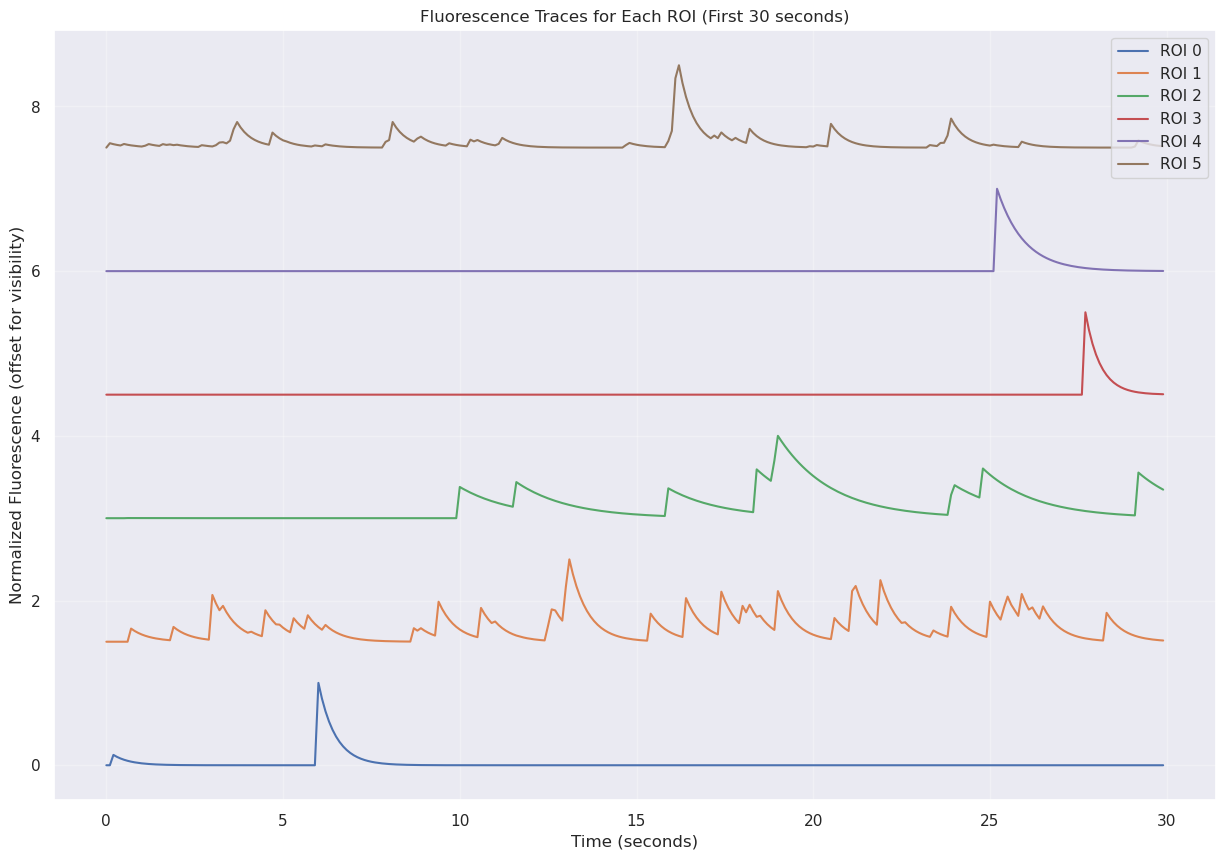

In [9]:
# Load just a subset of data (first 30 seconds) to avoid memory issues
subset_size = min(int(30 * sampling_rate), num_timepoints)
print(f"Analyzing first {subset_size} time points ({subset_size/sampling_rate:.2f} seconds)")

# Create time vector
time_vector = np.arange(subset_size) / sampling_rate

# Load the fluorescence data for the subset
fluorescence_data = roi_response.data[:subset_size, :]

# Plot the fluorescence traces for each ROI
plt.figure(figsize=(15, 10))
for i in range(num_rois):
    trace = fluorescence_data[:, i]
    # Check if all values are the same to avoid divide by zero
    if np.max(trace) > np.min(trace):  # Only normalize if we have variation
        normalized_trace = (trace - np.min(trace)) / (np.max(trace) - np.min(trace))
    else:
        normalized_trace = np.zeros_like(trace)
    
    # Plot with offset for better visibility
    plt.plot(time_vector, normalized_trace + i*1.5, label=f'ROI {i}')

plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Fluorescence (offset for visibility)')
plt.title('Fluorescence Traces for Each ROI (First 30 seconds)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Analyzing Event Amplitudes

The event amplitudes represent detected calcium events, which correspond to action potentials or bursts of activity in the neurons. Let's look at these events over time.

In [10]:
# Get the event amplitude data
event_amp = ophys.data_interfaces["EventAmplitude"]

print("Event amplitude data information:")
print(f"Number of time points: {event_amp.data.shape[0]}")
print(f"Number of ROIs: {event_amp.data.shape[1]}")
print(f"Sampling rate: {event_amp.rate} Hz")

# Note the small difference in sampling rates
if abs(event_amp.rate - roi_response.rate) > 1e-6:
    print(f"\nNote: The event amplitude sampling rate ({event_amp.rate} Hz) differs slightly from")
    print(f"the fluorescence data sampling rate ({roi_response.rate} Hz). This small difference")
    print("is likely due to rounding or internal calculation differences.")

Event amplitude data information:
Number of time points: 6026
Number of ROIs: 6
Sampling rate: 10.003722380947028 Hz

Note: The event amplitude sampling rate (10.003722380947028 Hz) differs slightly from
the fluorescence data sampling rate (10.0 Hz). This small difference
is likely due to rounding or internal calculation differences.


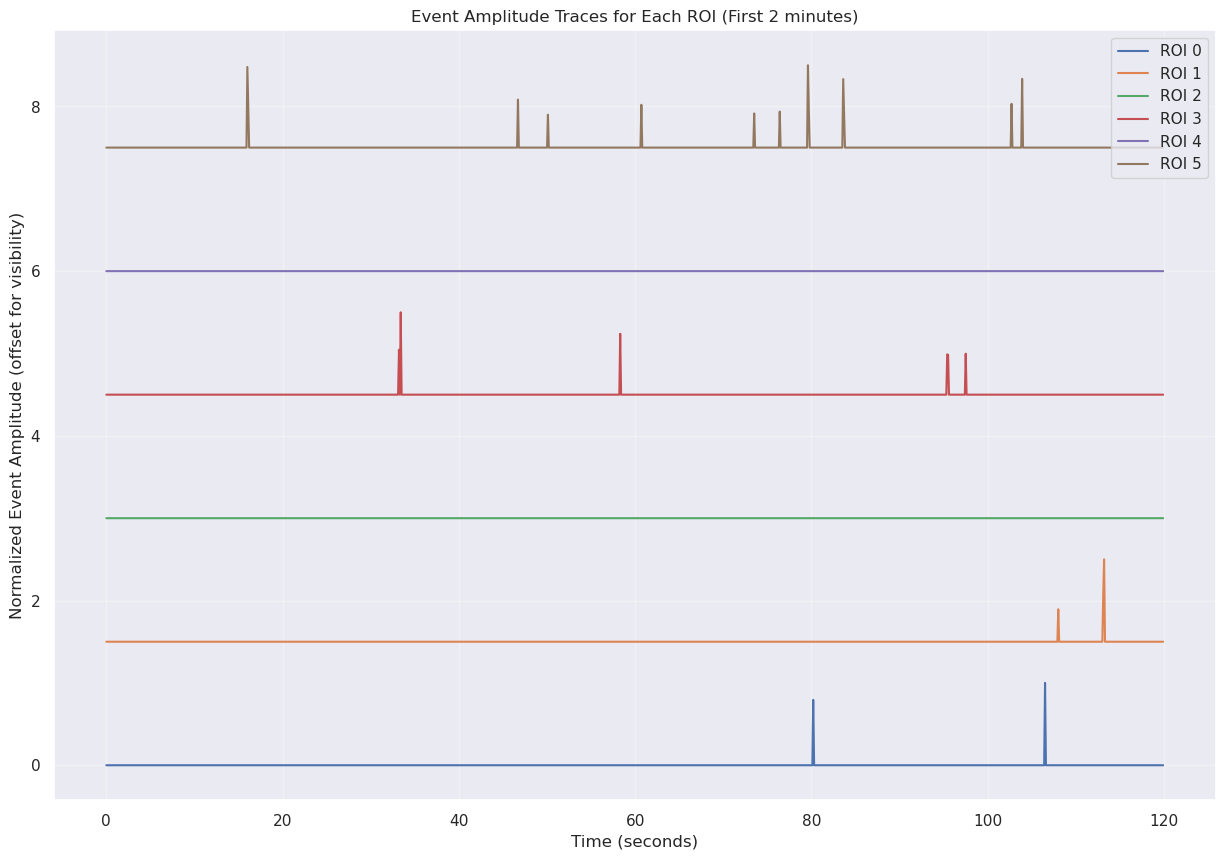

In [11]:
# Plot a longer time window (2 minutes) for event amplitudes
longer_subset = min(int(120 * sampling_rate), num_timepoints)
time_vector_long = np.arange(longer_subset) / sampling_rate
event_amplitude_data = event_amp.data[:longer_subset, :]

# Plot the event amplitude traces
plt.figure(figsize=(15, 10))
for i in range(num_rois):
    trace = event_amplitude_data[:, i]
    if np.max(trace) > np.min(trace):  # Only normalize if we have variation
        normalized_trace = (trace - np.min(trace)) / (np.max(trace) - np.min(trace))
    else:
        normalized_trace = np.zeros_like(trace)
    
    # Plot with offset for better visibility
    plt.plot(time_vector_long, normalized_trace + i*1.5, label=f'ROI {i}')

plt.xlabel('Time (seconds)')
plt.ylabel('Normalized Event Amplitude (offset for visibility)')
plt.title('Event Amplitude Traces for Each ROI (First 2 minutes)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Computing Correlation Between ROIs

Let's analyze how the different ROIs (neurons) are correlated with each other by computing the correlation matrix of their fluorescence signals.

In [12]:
# Compute correlation matrix between ROI fluorescence traces
# Use a longer window for better estimation
correlation_window = min(int(300 * sampling_rate), num_timepoints)  # 5 minutes or max available
fluorescence_data_corr = roi_response.data[:correlation_window, :]

# Check for ROIs with meaningful variance (using a small threshold rather than zero)
valid_rois = []
for i in range(num_rois):
    if np.std(fluorescence_data_corr[:, i]) > 1e-6:  # Better threshold than var > 0
        valid_rois.append(i)

print(f"\nIdentified {len(valid_rois)} ROIs with meaningful variance for correlation analysis")

# Display basic statistics for each ROI's fluorescence trace
print("\nBasic statistics for each ROI's fluorescence trace:")
stats_table = []
for i in range(num_rois):
    trace = fluorescence_data_corr[:, i]
    stats = {
        "ROI": i,
        "Mean": np.mean(trace),
        "Std Dev": np.std(trace),
        "Min": np.min(trace),
        "Max": np.max(trace),
        "Has Variance": i in valid_rois
    }
    stats_table.append(stats)

# Create a pandas DataFrame for better display
if pd is not None:  # Check if pandas is available
    stats_df = pd.DataFrame(stats_table)
    display(stats_df)
else:
    # Fallback if pandas is not available
    for stats in stats_table:
        print(f"ROI {stats['ROI']}: Mean={stats['Mean']:.2f}, Std={stats['Std Dev']:.2f}, Min={stats['Min']:.2f}, Max={stats['Max']:.2f}")

# Only include ROIs with variance
if len(valid_rois) > 1:
    valid_data = fluorescence_data_corr[:, valid_rois]
    # Compute correlation matrix and handle NaNs
    correlation_matrix = np.corrcoef(valid_data.T)
    # Handle NaNs that can occur when a trace has zero variance
    correlation_matrix = np.nan_to_num(correlation_matrix, nan=0.0)

    # Plot correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1,
               xticklabels=[f'ROI {i}' for i in valid_rois],
               yticklabels=[f'ROI {i}' for i in valid_rois])
    plt.title('Correlation Between ROI Fluorescence Traces')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough valid ROIs with variance to compute correlation")


Identified 0 ROIs with meaningful variance for correlation analysis

Basic statistics for each ROI's fluorescence trace:


,ROI,Mean,Std Dev,Min,Max,Has Variance
0,0,NaN,NaN,NaN,NaN,False
1,1,NaN,NaN,NaN,NaN,False
2,2,NaN,NaN,NaN,NaN,False
3,3,NaN,NaN,NaN,NaN,False
4,4,NaN,NaN,NaN,NaN,False
5,5,NaN,NaN,NaN,NaN,False


Not enough valid ROIs with variance to compute correlation


## Summary of Findings

In this notebook, we've explored Dandiset 001174, which contains calcium imaging data from the supplementary motor area (SMA) and primary motor cortex (M1) of macaque monkeys during rest and during an arm reaching task. We've learned how to:

1. Load the dataset using the DANDI API
2. Examine the structure of an NWB file from this dataset
3. Visualize ROI masks that represent the spatial footprints of neurons
4. Analyze fluorescence traces and event amplitudes that correspond to neural activity
5. Compute correlations between ROIs to identify related neurons

## Potential Future Directions

Here are some potential directions for further analysis:

1. **Session comparison**: Compare neural activity between rest and task conditions
2. **Cross-area comparison**: Compare neural activity between SMA and M1
3. **Temporal analysis**: Examine the timing and sequences of neural activations
4. **Population analysis**: Study how groups of neurons coordinate their activity
5. **Relationship to behavior**: Correlate neural activity with behavioral measures like reaction time or movement parameters

## Acknowledgments

This notebook is based on data from the following contributors:

Galvan, Adriana; Martel, Anne-Caroline; Pittard, Damien; Devergnas, Annaelle; Risk, Benjamin; Nassi, Jonathan J.; Yu, Waylin; Downer, Joshua D.; Wichmann, Thomas